# Introduction

Formula 1 is a sport driven by both engineering precision and strategic brilliance. The outcome of a race depends on a complex interplay of factors—driver performance, constructor reliability, track conditions, and more.

In this project, I aim to build a Machine Learning model capable of predicting whether a driver will finish on the podium (Top 3) in a given race. Using historical F1 data, I will explore trends and relationships between features such as qualifying positions, constructor standings, driver rankings, and race circuits to generate meaningful predictions.

This notebook walks through:

- Data preparation and feature engineering

- Exploratory Data Analysis (EDA)

- Building and evaluating multiple classification models

- Comparing model performances

- Drawing conclusions from the results

The goal is not just to make an accurate binary classifier, but to learn how to approach predictive modeling on structured, real-world datasets. 



### 

Note

When we mention constructor, it implies nothing but the team which is racing. For example saying "5 constructors ranked very closely" would imply "5 teams ranked very closely"

# Data Import


In [7]:
import pandas as pd

# Constructor ID
constructors_df = pd.read_csv('Data/constructors.csv')

# Driver ID
drivers_df = pd.read_csv('Data/drivers.csv')

# Race ID
races = pd.read_csv('Data/races.csv')

# Starting grid and final position of every driver in every race including associated status
results_df = pd.read_csv('Data/results.csv')

In [9]:
print(results_df)

       resultId  raceId  driverId  constructorId number  grid position  \
0             1      18         1              1     22     1        1   
1             2      18         2              2      3     5        2   
2             3      18         3              3      7     7        3   
3             4      18         4              4      5    11        4   
4             5      18         5              1     23     3        5   
...         ...     ...       ...            ...    ...   ...      ...   
26075     26081    1110       817            213      3    19       16   
26076     26082    1110       858              3      2    18       17   
26077     26083    1110       807            210     27     0       18   
26078     26084    1110       832              6     55     4       \N   
26079     26085    1110       857              1     81     5       \N   

      positionText  positionOrder  points  laps         time milliseconds  \
0                1              1 

In [11]:
print(results_df.columns)

Index(['resultId', 'raceId', 'driverId', 'constructorId', 'number', 'grid',
       'position', 'positionText', 'positionOrder', 'points', 'laps', 'time',
       'milliseconds', 'fastestLap', 'rank', 'fastestLapTime',
       'fastestLapSpeed', 'statusId'],
      dtype='object')


We have an array of columns from which we will only extract relevant features 

In [14]:
race_df = races[["raceId", "year", "round", "circuitId"]].copy()

# EDA and Preprocessing 

In [17]:
import pandas as pd
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier

In [18]:
# Starting Grid Position and final grid position at the end of the race; also includes the status of each constructor 
print("Driver result of a race:\n")
print(results_df.head())

print("\nRace_df dataframe:\n")
print(race_df.head())

Driver result of a race:

   resultId  raceId  driverId  constructorId number  grid position  \
0         1      18         1              1     22     1        1   
1         2      18         2              2      3     5        2   
2         3      18         3              3      7     7        3   
3         4      18         4              4      5    11        4   
4         5      18         5              1     23     3        5   

  positionText  positionOrder  points  laps         time milliseconds  \
0            1              1    10.0    58  1:34:50.616      5690616   
1            2              2     8.0    58       +5.478      5696094   
2            3              3     6.0    58       +8.163      5698779   
3            4              4     5.0    58      +17.181      5707797   
4            5              5     4.0    58      +18.014      5708630   

  fastestLap rank fastestLapTime fastestLapSpeed  statusId  
0         39    2       1:27.452         218.300     

Our dataset includes data from before 1982. We will ignore data from before 1891 as cars were significantly different from cars after 1982. We will ignore these cars as they output drastically lap timings.

In [20]:
race_df = race_df.sort_values(by=['year', 'round'])

race_df = race_df[race_df["year"] >= 1982]

print(race_df)

      raceId  year  round  circuitId
466      467  1982      1         30
467      468  1982      2         36
468      469  1982      3         43
469      470  1982      4         21
470      471  1982      5         40
...      ...   ...    ...        ...
1096    1116  2023     18         69
1097    1117  2023     19         32
1098    1118  2023     20         18
1099    1119  2023     21         80
1100    1120  2023     22         24

[744 rows x 4 columns]


Extract relevant features from the original dataframe

In [22]:
res_df = results_df[['raceId', 'driverId', 'constructorId', 'grid', 'positionOrder']].copy()
print(res_df)

# Checking Duplicates
duplicates = race_df.duplicated()
num_duplicates = duplicates.sum()
print(f"Number of duplicate rows: {num_duplicates}") 
print(race_df)

       raceId  driverId  constructorId  grid  positionOrder
0          18         1              1     1              1
1          18         2              2     5              2
2          18         3              3     7              3
3          18         4              4    11              4
4          18         5              1     3              5
...       ...       ...            ...   ...            ...
26075    1110       817            213    19             16
26076    1110       858              3    18             17
26077    1110       807            210     0             18
26078    1110       832              6     4             19
26079    1110       857              1     5             20

[26080 rows x 5 columns]
Number of duplicate rows: 0
      raceId  year  round  circuitId
466      467  1982      1         30
467      468  1982      2         36
468      469  1982      3         43
469      470  1982      4         21
470      471  1982      5         40
... 

Since there are no duplicates, we can proceed to merge the two datasets to obtain information about the year, the round and the circuit for a specific race.

In [24]:
df = pd.merge(race_df, res_df, on='raceId')
print(df)

       raceId  year  round  circuitId  driverId  constructorId  grid  \
0         467  1982      1         30       117              4     5   
1         467  1982      1         30       199              3     8   
2         467  1982      1         30       163              4     1   
3         467  1982      1         30       182              1    13   
4         467  1982      1         30       177              3     7   
...       ...   ...    ...        ...       ...            ...   ...   
17316    1110  2023     12         13       817            213    19   
17317    1110  2023     12         13       858              3    18   
17318    1110  2023     12         13       807            210     0   
17319    1110  2023     12         13       832              6     4   
17320    1110  2023     12         13       857              1     5   

       positionOrder  
0                  1  
1                  2  
2                  3  
3                  4  
4                  5

In [25]:
# Checking datatypes
df.dtypes

# Cheking null values
df.isna().sum()

raceId           0
year             0
round            0
circuitId        0
driverId         0
constructorId    0
grid             0
positionOrder    0
dtype: int64

In [26]:
# Summary Statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
raceId,17321.0,477.446510,349.475072,1.0,206.0,364.0,881.0,1110.0
year,17321.0,2001.829687,12.253518,1982.0,1991.0,2001.0,2013.0,2023.0
round,17321.0,9.240517,5.183158,1.0,5.0,9.0,13.0,22.0
circuitId,17321.0,19.726863,17.794540,1.0,8.0,14.0,25.0,79.0
driverId,17321.0,225.175914,307.095663,1.0,23.0,94.0,173.0,858.0
constructorId,17321.0,35.653426,55.326192,1.0,6.0,17.0,33.0,214.0
grid,17321.0,11.281508,7.041134,0.0,5.0,11.0,17.0,29.0
positionOrder,17321.0,12.716009,7.606928,1.0,6.0,12.0,18.0,39.0


Bar plot of Number of races per year:

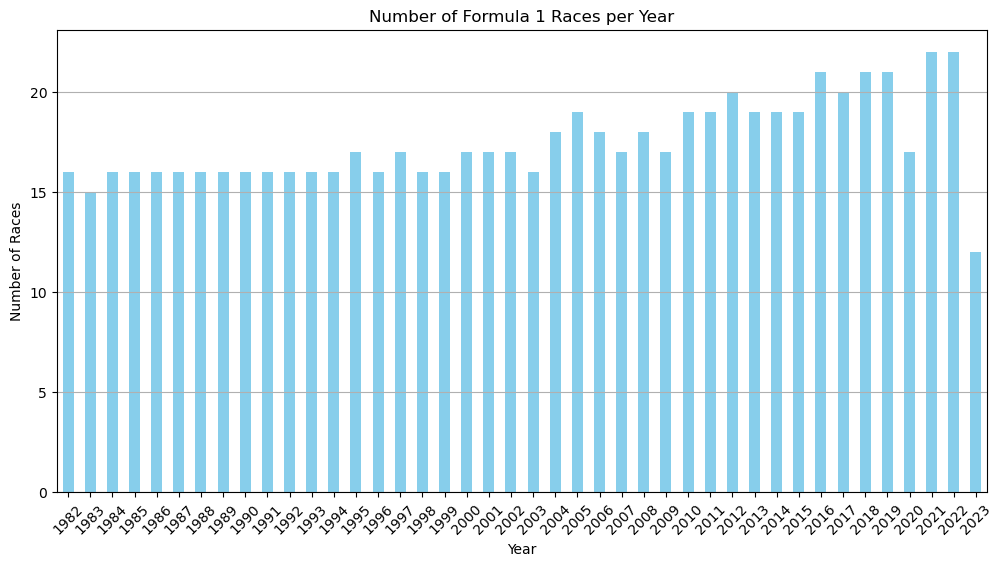

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Group data by 'year' and count the number of races
races_per_year = df.groupby('year')['raceId'].nunique()

# Create a bar plot
plt.figure(figsize=(12, 6)) 
races_per_year.plot(kind='bar', color='skyblue')

plt.title('Number of Formula 1 Races per Year')
plt.xlabel('Year')
plt.ylabel('Number of Races')
plt.xticks(rotation=45)  # Rotates the x-axis labels for better readability
plt.grid(axis='y')

plt.show()

Exploring teams which have participated in most races (50th percentile i.e. 15 teams) since 1982:

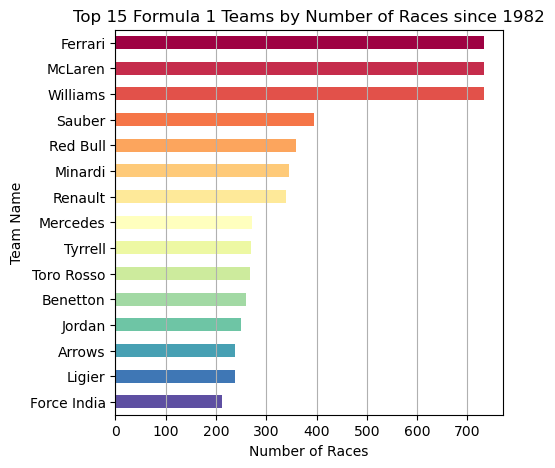

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

races_per_team = df.groupby('constructorId')['raceId'].nunique()

# Create a dictionary to map 'constructorId' to 'name'
constructor_name_dict = pd.Series(constructors_df.name.values, index=constructors_df.constructorId).to_dict()

# Replace 'constructorId' with corresponding 'name' in races_per_team
races_per_team.index = races_per_team.index.map(constructor_name_dict)

# Sort the data from most races to least races and select top 15
races_per_team_sorted = races_per_team.sort_values(ascending=False).head(15)

# Bar plot
plt.figure(figsize=(5,5))  # Adjust the figure size to your preference
colors = plt.cm.Spectral(np.linspace(0, 1, len(races_per_team_sorted))) # Using Spectral colormap
races_per_team_sorted.plot(kind='barh', color=colors)

plt.title('Top 15 Formula 1 Teams by Number of Races since 1982')
plt.ylabel('Team Name')
plt.xlabel('Number of Races')
plt.grid(axis='x')

# Reverse the order of the y-axis so the team with most races is on top
plt.gca().invert_yaxis()

plt.show()

Just like we did for constructors, we will also see drivers who have participated in the most races


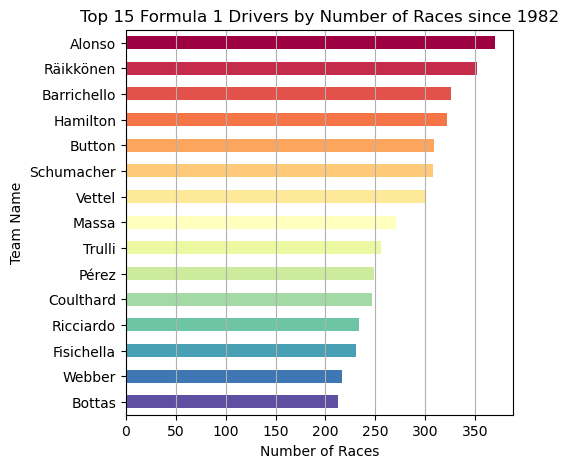

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Group data by 'driverId' and count unique races
races_per_team = df.groupby('driverId')['raceId'].nunique()

# Create a dictionary to map 'driverId' to 'name'
driver_name_dict = pd.Series(drivers_df.surname.values, index=drivers_df.driverId).to_dict()

# Replace 'driverId' with corresponding 'name' in races_per_team
races_per_team.index = races_per_team.index.map(driver_name_dict)

# Sort the data from most races to least races and select top 15
races_per_team_sorted = races_per_team.sort_values(ascending=False).head(15)

# Bar plot
plt.figure(figsize=(5, 5))  # Adjust the figure size to your preference
colors = plt.cm.Spectral(np.linspace(0, 1, len(races_per_team_sorted))) # Using Spectral colormap
races_per_team_sorted.plot(kind='barh', color=colors)

plt.title('Top 15 Formula 1 Drivers by Number of Races since 1982')
plt.ylabel('Team Name')
plt.xlabel('Number of Races')
plt.grid(axis='x')

# Reverse the order of the y-axis so the team with most races is on top
plt.gca().invert_yaxis()

plt.show()

Histograms of Starting and finishing positions

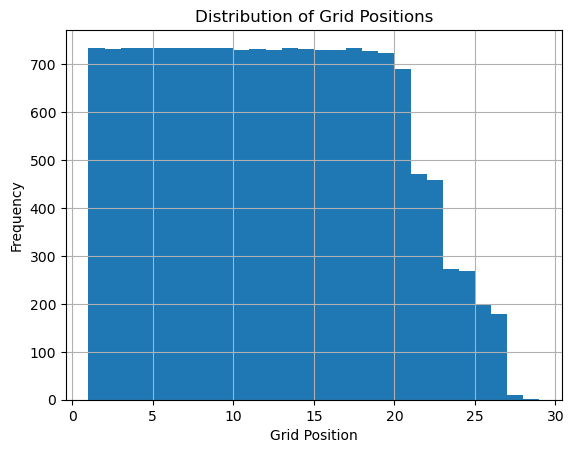

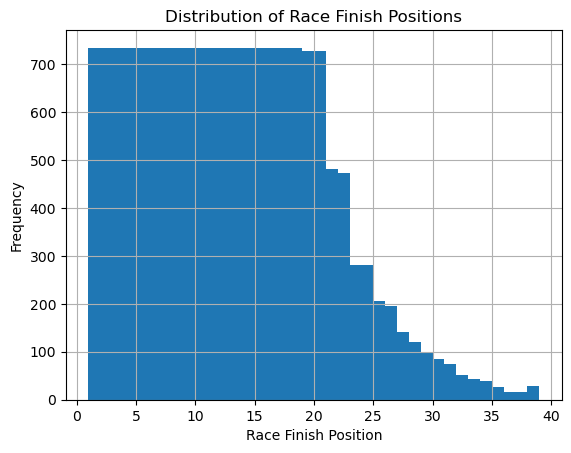

In [41]:
# Histogram of grid positions
df_nonZero = df[df['grid']!=0]
df_nonZero['grid'].hist(bins=28)
plt.title('Distribution of Grid Positions')
plt.xlabel('Grid Position')
plt.ylabel('Frequency')
plt.show()

# Histogram of positionOrder
df['positionOrder'].hist(bins=38)
plt.title('Distribution of Race Finish Positions')
plt.xlabel('Race Finish Position')
plt.ylabel('Frequency')

plt.show()

# Feature Engineering

## Add Target Variable: 'Top 3 Finish'

In [46]:
# Creating a column for Top 3 Finish
df['Top 3 Finish'] = df['positionOrder'].le(3).astype(int)

# Display the first few rows to confirm the new column
print(df)

# To confirm we have the correct data
numberRace = df["raceId"].nunique()
print(f"Number of unique drivers: {numberRace}")

       raceId  year  round  circuitId  driverId  constructorId  grid  \
0         467  1982      1         30       117              4     5   
1         467  1982      1         30       199              3     8   
2         467  1982      1         30       163              4     1   
3         467  1982      1         30       182              1    13   
4         467  1982      1         30       177              3     7   
...       ...   ...    ...        ...       ...            ...   ...   
17316    1110  2023     12         13       817            213    19   
17317    1110  2023     12         13       858              3    18   
17318    1110  2023     12         13       807            210     0   
17319    1110  2023     12         13       832              6     4   
17320    1110  2023     12         13       857              1     5   

       positionOrder  Top 3 Finish  
0                  1             1  
1                  2             1  
2                  3    

## Past Performance

In order to ascertain driver performance and predict future race result, we can compute driver AND constructor's percentage of finishing in the top 3. We will only take into account performance in last year and the result up to the previous race, intentionally leaving out current race in order to prevent data leakage. We are only considering data upto last year as significant changes occur over a span of 12 months and hence a team which was performing well last year may not perform well this year.

### Driver Performance

In [52]:
# Calculating the total number of races and top 3 finishes for each driver in each year
driver_yearly_stats = df.groupby(['year', 'driverId']).agg(
    Total_Races=('raceId', 'nunique'),
    Top_3_Finishes=('Top 3 Finish', 'sum')
).reset_index()

print("Driver annual stats")
print(driver_yearly_stats)

# Calculating the percentage of top 3 finishes for each driver in each year
driver_yearly_stats['Driver Top 3 Finish Percentage (This Year)'] = (driver_yearly_stats['Top_3_Finishes'] / driver_yearly_stats['Total_Races']) * 100

# Shifting the driver percentages to the next year for last year's data
driver_last_year_stats = driver_yearly_stats.copy()
driver_last_year_stats['year'] += 1
driver_last_year_stats = driver_last_year_stats.rename(columns={'Driver Top 3 Finish Percentage (This Year)': 'Driver Top 3 Finish Percentage (Last Year)'})

df = pd.merge(df, driver_last_year_stats[['year', 'driverId', 'Driver Top 3 Finish Percentage (Last Year)']], on=['year', 'driverId'], how='left')

# Checking the merged data
print("New dataframe")
print(df[df["year"]>=1983])

Driver annual stats
      year  driverId  Total_Races  Top_3_Finishes
0     1982        90            1               0
1     1982        95           13               1
2     1982       105           16               2
3     1982       110           16               1
4     1982       117           16               4
...    ...       ...          ...             ...
1194  2023       852           12               0
1195  2023       855           12               0
1196  2023       856           10               0
1197  2023       857           12               0
1198  2023       858           12               0

[1199 rows x 4 columns]
New dataframe
       raceId  year  round  circuitId  driverId  constructorId  grid  \
465       452  1983      1         36       137             34     4   
466       452  1983      1         36       182              1     9   
467       452  1983      1         36       172              3    18   
468       452  1983      1         36       175      

In [54]:
print(df[df["year"]>=1982])

       raceId  year  round  circuitId  driverId  constructorId  grid  \
0         467  1982      1         30       117              4     5   
1         467  1982      1         30       199              3     8   
2         467  1982      1         30       163              4     1   
3         467  1982      1         30       182              1    13   
4         467  1982      1         30       177              3     7   
...       ...   ...    ...        ...       ...            ...   ...   
17316    1110  2023     12         13       817            213    19   
17317    1110  2023     12         13       858              3    18   
17318    1110  2023     12         13       807            210     0   
17319    1110  2023     12         13       832              6     4   
17320    1110  2023     12         13       857              1     5   

       positionOrder  Top 3 Finish  Driver Top 3 Finish Percentage (Last Year)  
0                  1             1                    

### Constructor Performance

In [58]:
# Calculating mean of top 3 finishes percentages for the two drivers in each constructor last year
constructor_last_year_stats = df.groupby(['year', 'constructorId', 'round']).agg(
    Sum_Top_3_Finishes_Last_Year=('Driver Top 3 Finish Percentage (Last Year)', 'sum')
).reset_index()

print("Constructor annual stats")
print(constructor_last_year_stats)

# Calculating the percentage of top 3 finishes for each constructor last year
constructor_last_year_stats['Constructor Top 3 Finish Percentage (Last Year)'] = constructor_last_year_stats["Sum_Top_3_Finishes_Last_Year"]/2

df = pd.merge(df, constructor_last_year_stats[['year', 'constructorId', 'round', 'Constructor Top 3 Finish Percentage (Last Year)']], on=['year', 'constructorId', 'round'], how='left')

# Checking the merged data
print("New dataframe")
print(df[df["year"]>=1983])

Constructor annual stats
      year  constructorId  round  Sum_Top_3_Finishes_Last_Year
0     1982              1      1                           0.0
1     1982              1      2                           0.0
2     1982              1      3                           0.0
3     1982              1      5                           0.0
4     1982              1      6                           0.0
...    ...            ...    ...                           ...
8878  2023            214      8                           0.0
8879  2023            214      9                           0.0
8880  2023            214     10                           0.0
8881  2023            214     11                           0.0
8882  2023            214     12                           0.0

[8883 rows x 4 columns]
New dataframe
       raceId  year  round  circuitId  driverId  constructorId  grid  \
465       452  1983      1         36       137             34     4   
466       452  1983      1         3

### Driver Performance upto previous race (ongoing season)

In [61]:
# Creating a function to calculate the top 3 finish percentage before the current round for drivers
def calculate_driver_top_3_percentage_before_round(row, df):
    # Filter for races in the same year, for the same driver, but in earlier rounds
    previous_races = df[(df['year'] == row['year']) & (df['driverId'] == row['driverId']) & (df['round'] < row['round'])]
    if len(previous_races) == 0:
      return pd.NA

    total_races = previous_races['raceId'].nunique()
    top_3_finishes = previous_races['Top 3 Finish'].sum()

    # Calculate the percentage
    return (top_3_finishes / total_races) * 100 if total_races > 0 else pd.NA

# Apply the function to each row in the DataFrame
df['Driver Top 3 Finish Percentage (This Year till last race)'] = df.apply(lambda row: calculate_driver_top_3_percentage_before_round(row, df), axis=1)


### Constructor Performance upto previous race (ongoing season)

In [63]:
# Calculating mean of top 3 finishes percentages for the two drivers in each constructor this year
constructor_this_year_stats = df.groupby(['year', 'constructorId', 'round']).agg(
    Sum_Top_3_Finishes_This_Year=('Driver Top 3 Finish Percentage (This Year till last race)', 'sum')
).reset_index()

print("Constructor annual stats")
print(constructor_this_year_stats)

# Calculating the percentage of top 3 finishes for each constructor this year
constructor_this_year_stats['Constructor Top 3 Finish Percentage (This Year till last race)'] = constructor_this_year_stats["Sum_Top_3_Finishes_This_Year"]/2

df = pd.merge(df, constructor_this_year_stats[['year', 'constructorId', 'round', 'Constructor Top 3 Finish Percentage (This Year till last race)']], on=['year', 'constructorId', 'round'], how='left')

# Checking the merged data
print("New dataframe")
print(df[df["year"]>=1983])

Constructor annual stats
      year  constructorId  round Sum_Top_3_Finishes_This_Year
0     1982              1      1                            0
1     1982              1      2                          0.0
2     1982              1      3                         50.0
3     1982              1      5                    66.666667
4     1982              1      6                         75.0
...    ...            ...    ...                          ...
8878  2023            214      8                    14.285714
8879  2023            214      9                         12.5
8880  2023            214     10                    11.111111
8881  2023            214     11                         10.0
8882  2023            214     12                     9.090909

[8883 rows x 4 columns]
New dataframe
       raceId  year  round  circuitId  driverId  constructorId  grid  \
465       452  1983      1         36       137             34     4   
466       452  1983      1         36       182 

## Past performance features: average finishing position

### Driver

In [66]:
# Calculating the total number of races and top 3 finishes for each driver in each year
driver_yearly_stats = df.groupby(['year', 'driverId']).agg(
    Total_Races=('raceId', 'nunique'),
    Avg_position=('positionOrder', 'mean')
).reset_index()

print("Driver annual stats")
print(driver_yearly_stats)

# Calculating the percentage of top 3 finishes for each driver in each year
driver_yearly_stats['Driver Avg position (This Year)'] = driver_yearly_stats['Avg_position']

# Shifting the driver percentages to the next year for last year's data
driver_last_year_stats = driver_yearly_stats.copy()
driver_last_year_stats['year'] += 1
driver_last_year_stats = driver_last_year_stats.rename(columns={'Driver Avg position (This Year)': 'Driver Avg position (Last Year)'})

df = pd.merge(df, driver_last_year_stats[['year', 'driverId', 'Driver Avg position (Last Year)']], on=['year', 'driverId'], how='left')

# Checking the merged data
print("New dataframe")
print(df[df["year"]>=1983])

Driver annual stats
      year  driverId  Total_Races  Avg_position
0     1982        90            1     30.000000
1     1982        95           13     13.692308
2     1982       105           16      9.000000
3     1982       110           16     14.437500
4     1982       117           16     10.000000
...    ...       ...          ...           ...
1194  2023       852           12     12.833333
1195  2023       855           12     13.916667
1196  2023       856           10     15.900000
1197  2023       857           12     12.666667
1198  2023       858           12     16.416667

[1199 rows x 4 columns]
New dataframe
       raceId  year  round  circuitId  driverId  constructorId  grid  \
465       452  1983      1         36       137             34     4   
466       452  1983      1         36       182              1     9   
467       452  1983      1         36       172              3    18   
468       452  1983      1         36       175              6     3   
469  

### Constructor

In [68]:
# Calculating mean of top 3 finishes percentages for the two drivers in each constructor last year
constructor_last_year_stats = df.groupby(['year', 'constructorId', 'round']).agg(
    sum_position_last_year=('Driver Avg position (Last Year)', 'sum')
).reset_index()

print("Constructor annual stats")
print(constructor_last_year_stats)

# Calculating the percentage of top 3 finishes for each constructor last year
constructor_last_year_stats['Constructor Avg position (Last Year)'] = constructor_last_year_stats["sum_position_last_year"]/2

df = pd.merge(df, constructor_last_year_stats[['year', 'constructorId', 'round', 'Constructor Avg position (Last Year)']], on=['year', 'constructorId', 'round'], how='left')

# Checking the merged data
print("New dataframe")
print(df[df["year"]>=1983])

Constructor annual stats
      year  constructorId  round  sum_position_last_year
0     1982              1      1                0.000000
1     1982              1      2                0.000000
2     1982              1      3                0.000000
3     1982              1      5                0.000000
4     1982              1      6                0.000000
...    ...            ...    ...                     ...
8878  2023            214      8               21.318182
8879  2023            214      9               21.318182
8880  2023            214     10               21.318182
8881  2023            214     11               21.318182
8882  2023            214     12               21.318182

[8883 rows x 4 columns]
New dataframe
       raceId  year  round  circuitId  driverId  constructorId  grid  \
465       452  1983      1         36       137             34     4   
466       452  1983      1         36       182              1     9   
467       452  1983      1         3

### Driver average finishing position up till previous race (ongoing season)

In [70]:
def calculate_driver_avg_position_before_round(row, df):
    # Filter for races in the same year, for the same driver, but in earlier rounds
    previous_races = df[(df['year'] == row['year']) & (df['driverId'] == row['driverId']) & (df['round'] < row['round'])]
    if len(previous_races) == 0:
      return pd.NA
    # Calculate the total races and sum of positions
    total_races = previous_races['raceId'].nunique()
    positionSum = previous_races['positionOrder'].sum()

    # Calculate average position
    return (positionSum / total_races) if total_races > 0 else pd.NA

# Apply the function to each row in the DataFrame
df['Driver Average Position (This Year till last race)'] = df.apply(lambda row: calculate_driver_avg_position_before_round(row, df), axis=1)


### Constructor Average finishing position up till previous race (ongoing season)

In [72]:
# Calculating mean of top 3 finishes percentages for the two drivers in each constructor this year
constructor_this_year_stats = df.groupby(['year', 'constructorId', 'round']).agg(
    sum_Position_Constructor = ('Driver Average Position (This Year till last race)', 'sum')
).reset_index()

print("Constructor annual stats")
print(constructor_this_year_stats)

# Calculating the percentage of top 3 finishes for each constructor this year
constructor_this_year_stats['Constructor Average Position (This Year till last race)'] = constructor_this_year_stats["sum_Position_Constructor"]/2

df = pd.merge(df, constructor_this_year_stats[['year', 'constructorId', 'round', 'Constructor Average Position (This Year till last race)']], on=['year', 'constructorId', 'round'], how='left')

# Checking the merged data
print("New dataframe")
print(df[df["year"]>=1983])

Constructor annual stats
      year  constructorId  round sum_Position_Constructor
0     1982              1      1                        0
1     1982              1      2                     10.0
2     1982              1      3                     14.5
3     1982              1      5                     12.0
4     1982              1      6                    11.75
...    ...            ...    ...                      ...
8878  2023            214      8                20.714286
8879  2023            214      9                   20.625
8880  2023            214     10                     21.0
8881  2023            214     11                     22.7
8882  2023            214     12                24.181818

[8883 rows x 4 columns]
New dataframe
       raceId  year  round  circuitId  driverId  constructorId  grid  \
465       452  1983      1         36       137             34     4   
466       452  1983      1         36       182              1     9   
467       452  1983     

Confirm by examining 2023 data

In [74]:
print(df[(df["year"] == 2023)& (df["round"] > 3) ].head(30))

       raceId  year  round  circuitId  driverId  constructorId  grid  \
17141    1101  2023      4         73       815              9     3   
17142    1101  2023      4         73       830              9     2   
17143    1101  2023      4         73       844              6     1   
17144    1101  2023      4         73         4            117     6   
17145    1101  2023      4         73       832              6     4   
17146    1101  2023      4         73         1            131     5   
17147    1101  2023      4         73       840            117     9   
17148    1101  2023      4         73       847            131    11   
17149    1101  2023      4         73       846              1     7   
17150    1101  2023      4         73       852            213     8   
17151    1101  2023      4         73       857              1    10   
17152    1101  2023      4         73       848              3    12   
17153    1101  2023      4         73       825            210  

# Examine Dataframe

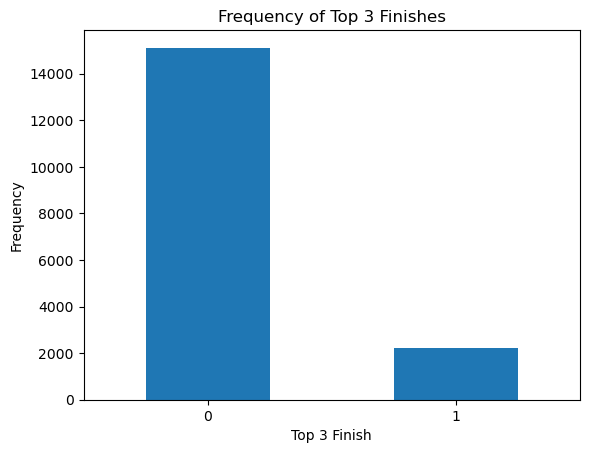

In [76]:



# Histogram for Top 3 Finishes
df['Top 3 Finish'].value_counts().plot(kind='bar')
plt.title('Frequency of Top 3 Finishes')
plt.xlabel('Top 3 Finish')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

In [77]:
nan_counts = df.isna().sum()
print(nan_counts)

raceId                                                               0
year                                                                 0
round                                                                0
circuitId                                                            0
driverId                                                             0
constructorId                                                        0
grid                                                                 0
positionOrder                                                        0
Top 3 Finish                                                         0
Driver Top 3 Finish Percentage (Last Year)                        3678
Constructor Top 3 Finish Percentage (Last Year)                      0
Driver Top 3 Finish Percentage (This Year till last race)         1199
Constructor Top 3 Finish Percentage (This Year till last race)       0
Driver Avg position (Last Year)                                   3678
Constr

Null values indicate that the driver did not participate last year

# Feature Selection

In [80]:
df_final = df.drop(labels=["raceId"], axis=1)

In [81]:
print("Number of rows in total:", df_final.shape[0])

# Count rows where 'year' is not 1982 before dropping NaN values
initial_count = len(df_final[df_final['year'] != 1982])

# Drop rows with NaN values
df_final = df_final.dropna()

# Count rows where 'year' is not 1982 after dropping NaN values
final_count = len(df_final[df_final['year'] != 1982])

# Calculate the number of rows dropped
rows_dropped = initial_count - final_count

print("Number of rows dropped where year is not 1982:", rows_dropped)
df_final_keepPositionOrder = df_final.copy()
df_final = df_final.drop(["positionOrder"], axis = 1)
print(df_final)

Number of rows in total: 17321
Number of rows dropped where year is not 1982: 4078
       year  round  circuitId  driverId  constructorId  grid  Top 3 Finish  \
493    1983      2         43       187              1    22             1   
494    1983      2         43       182              1    23             1   
495    1983      2         43       163              6     2             1   
496    1983      2         43       172              3     4             0   
497    1983      2         43       176             21    16             0   
...     ...    ...        ...       ...            ...   ...           ...   
17314  2023     12         13       848              3    15             0   
17315  2023     12         13       825            210    16             0   
17316  2023     12         13       817            213    19             0   
17318  2023     12         13       807            210     0             0   
17319  2023     12         13       832              6     

# 

EDA

In [83]:
df_final["Driver Top 3 Finish Percentage (This Year till last race)"] = df_final["Driver Top 3 Finish Percentage (This Year till last race)"].astype(float)
df_final["Constructor Top 3 Finish Percentage (This Year till last race)"] = df_final["Constructor Top 3 Finish Percentage (This Year till last race)"].astype(float)
df_final["Driver Average Position (This Year till last race)"] = df_final["Driver Average Position (This Year till last race)"].astype(float)
df_final["Constructor Average Position (This Year till last race)"] = df_final["Constructor Average Position (This Year till last race)"].astype(float)

In [84]:
# Using describe() and selecting specific rows
description = df_final.describe()
selected_description = description.loc[['count', 'mean', 'std', 'min', 'max']]

print(selected_description)

               year         round     circuitId      driverId  constructorId  \
count  12778.000000  12778.000000  12778.000000  12778.000000   12778.000000   
mean    2002.443262      9.734074     19.821960    212.344655      33.660119   
std       12.114476      4.922475     17.856984    302.097300      53.897616   
min     1983.000000      2.000000      1.000000      1.000000       1.000000   
max     2023.000000     22.000000     79.000000    856.000000     214.000000   

               grid  Top 3 Finish  Driver Top 3 Finish Percentage (Last Year)  \
count  12778.000000  12778.000000                                12778.000000   
mean      10.494209      0.152997                                   14.930460   
std        6.719308      0.359999                                   22.614169   
min        0.000000      0.000000                                    0.000000   
max       29.000000      1.000000                                  100.000000   

       Constructor Top 3 Finish 

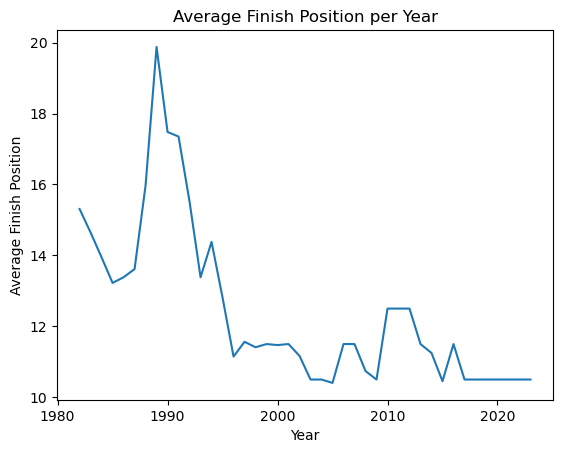

In [85]:
# Average finish position per year
avg_finish_per_year = df.groupby('year')['positionOrder'].mean()
avg_finish_per_year.plot(kind='line')
plt.title('Average Finish Position per Year')
plt.xlabel('Year')
plt.ylabel('Average Finish Position')
plt.show()

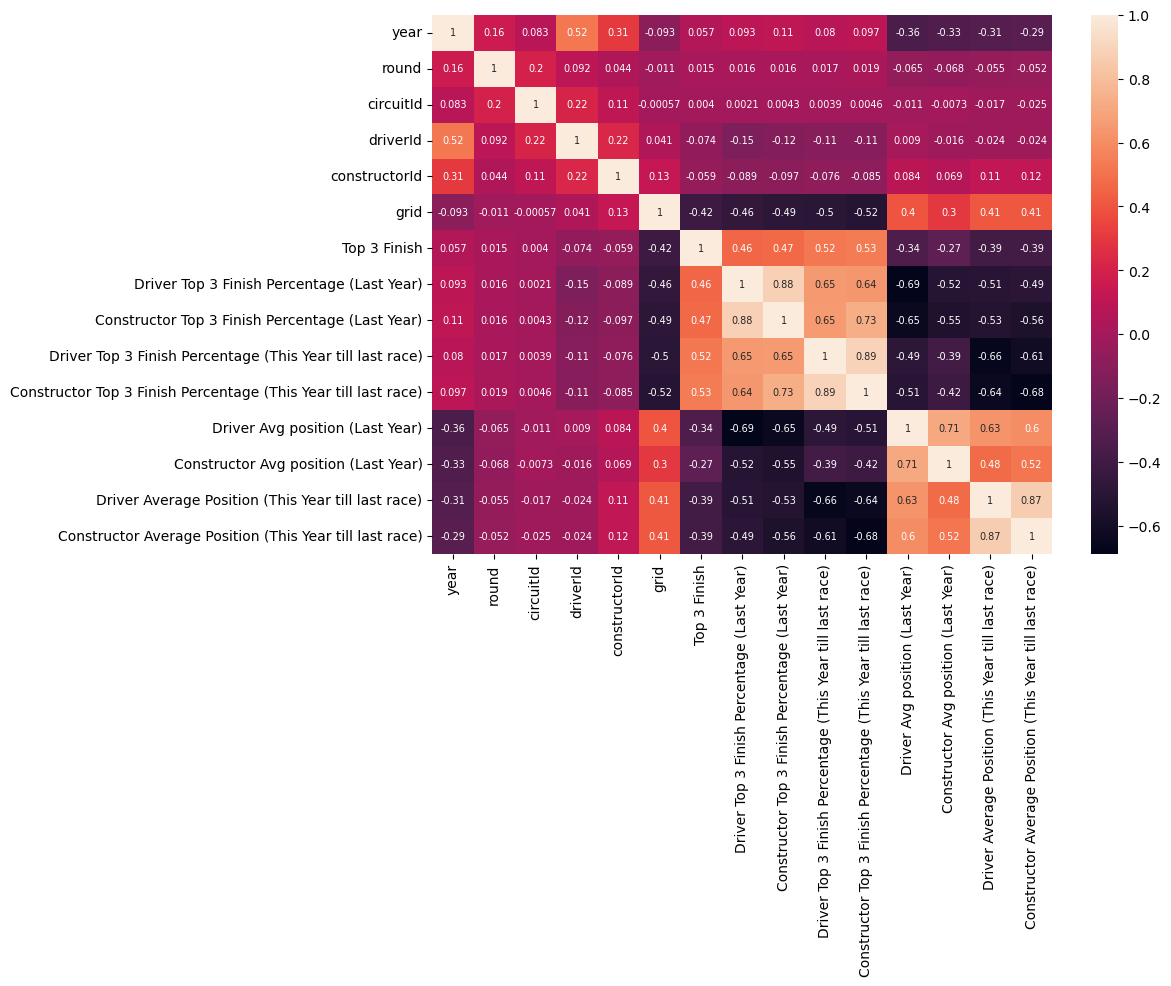

In [86]:
# heatmap
plt.figure(figsize=(10,7))
sns.heatmap(df_final.corr(), annot=True, mask = False, annot_kws={"size": 7})
plt.show()

We can see that the top 3 finish percentage for both drivers and constructors(teams) in the current and past year have strong positive correlations with the target variable `Top 3 Finish', which is whether the driver finishes in top 3 for this race. The values of these correlations are between 0.46 and 0.53.

In addition, grid (driver's starting position for this race) and average finishing positions for drivers and teams in the past and current year have negative correlations with the target variable `Top 3 Finish'. This is expected as when the starting position or average finishing position has a higher value, it's less likely for the car to finish in top 3.

Furthermore, several engineered features have some degree of correlations. For example, the correlation between 'Driver Top 3 Finish Percentage (Last Year)' and `Driver Top 3 Finish Percentage (This Year till last race)' is 0.65. But since they are not close to a perfect correlation, having an additional feature still has the potential to improve our classification model.

In [88]:
correlations = df_final.corr()['Top 3 Finish'].sort_values(ascending=False)

# Display
print(correlations)

Top 3 Finish                                                      1.000000
Constructor Top 3 Finish Percentage (This Year till last race)    0.533514
Driver Top 3 Finish Percentage (This Year till last race)         0.524211
Constructor Top 3 Finish Percentage (Last Year)                   0.466833
Driver Top 3 Finish Percentage (Last Year)                        0.457129
year                                                              0.056896
round                                                             0.015055
circuitId                                                         0.003994
constructorId                                                    -0.058801
driverId                                                         -0.073874
Constructor Avg position (Last Year)                             -0.272492
Driver Avg position (Last Year)                                  -0.338790
Driver Average Position (This Year till last race)               -0.385000
Constructor Average Posit

## One Hot Encoding

In [90]:
df_final_encoded = pd.get_dummies(df_final, columns=['circuitId', 'driverId', 'constructorId'])

In [91]:
# Create a list of columns excluding the one to move
cols = [col for col in df_final_encoded.columns if col != 'Top 3 Finish']

# Append the column to the end of the DataFrame
df_final_encoded = df_final_encoded[cols + ['Top 3 Finish']]

print(df_final_encoded)
print(df_final_encoded.shape)

       year  round  grid  Driver Top 3 Finish Percentage (Last Year)  \
493    1983      2    22                                   33.333333   
494    1983      2    23                                   21.428571   
495    1983      2     2                                   25.000000   
496    1983      2     4                                    6.666667   
497    1983      2    16                                    0.000000   
...     ...    ...   ...                                         ...   
17314  2023     12    15                                    0.000000   
17315  2023     12    16                                    0.000000   
17316  2023     12    19                                    0.000000   
17318  2023     12     0                                    0.000000   
17319  2023     12     4                                   40.909091   

       Constructor Top 3 Finish Percentage (Last Year)  \
493                                          27.380952   
494                

# Model Development - Without qualifying data


We will train our models in 3 steps, by starting with only a few features and adding more every step. This will enable us to evaluate the models and see how they react to every set of features.

### Training, Testing, Evaluation Split

Training data: year 1983 - 2008

Validation data: year 2009 - 2016

Test data: year 2017 - 2023

## Step 1: Features include Driver top 3 finish last year and constructor top 3 finish last year

In [97]:
print(df_final_encoded)

       year  round  grid  Driver Top 3 Finish Percentage (Last Year)  \
493    1983      2    22                                   33.333333   
494    1983      2    23                                   21.428571   
495    1983      2     2                                   25.000000   
496    1983      2     4                                    6.666667   
497    1983      2    16                                    0.000000   
...     ...    ...   ...                                         ...   
17314  2023     12    15                                    0.000000   
17315  2023     12    16                                    0.000000   
17316  2023     12    19                                    0.000000   
17318  2023     12     0                                    0.000000   
17319  2023     12     4                                   40.909091   

       Constructor Top 3 Finish Percentage (Last Year)  \
493                                          27.380952   
494                

In [98]:
df_1 = df_final_encoded.drop(["grid", "Driver Top 3 Finish Percentage (This Year till last race)", "Constructor Top 3 Finish Percentage (This Year till last race)", "Driver Average Position (This Year till last race)", "Constructor Average Position (This Year till last race)", "Driver Average Position (This Year till last race)", "Constructor Average Position (This Year till last race)"], axis = 1)


In [99]:
from sklearn.preprocessing import StandardScaler

train_df = df_1[(df_1["year"] >= 1983) & (df_1["year"] <= 2008)]
val_df = df_1[(df_1["year"] >= 2009) & (df_1["year"] <= 2016)]
test_df = df_1[(df_1["year"] >= 2017) & (df_1["year"] <= 2023)]

X_train = train_df[train_df.columns.tolist()[:-1]].values
y_train = train_df['Top 3 Finish'].values
X_val = val_df[train_df.columns.tolist()[:-1]].values
y_val = val_df['Top 3 Finish'].values
X_test = test_df[train_df.columns.tolist()[:-1]].values
y_test = test_df['Top 3 Finish'].values

## Model Metrics



Due to the presence of very high class imbalance i.e. majority of the class is "Driver does NOT finish in top 3", metrics like accuracy, recall, F1 score, etc are not apt. The use of AUC-ROC score takes into consderation the class imbalance and returns more accurate metrics.

Model: LogisticRegression
Best parameters for LogisticRegression: {'C': 0.001, 'random_state': 42}
Test AUC-ROC for LogisticRegression: 0.7867

Model: KNeighborsClassifier
Best parameters for KNeighborsClassifier: {'n_neighbors': 20}
Test AUC-ROC for KNeighborsClassifier: 0.8321

Model: SVC
Best parameters for SVC: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True, 'random_state': 42}
Test AUC-ROC for SVC: 0.5859

Model: RandomForestClassifier
Best parameters for RandomForestClassifier: {'max_depth': 20, 'n_estimators': 100, 'random_state': 42}
Test AUC-ROC for RandomForestClassifier: 0.8663

Model: DecisionTreeClassifier
Best parameters for DecisionTreeClassifier: {'max_depth': 5, 'random_state': 42}
Test AUC-ROC for DecisionTreeClassifier: 0.6182

Model: GaussianNB
Best parameters for GaussianNB: {'var_smoothing': 0.1}
Test AUC-ROC for GaussianNB: 0.8840

Model: LogisticRegression, File: LogisticRegression_model_V1.joblib, Test AUC-ROC: 0.7867, Test Accuracy: 0.8225
M

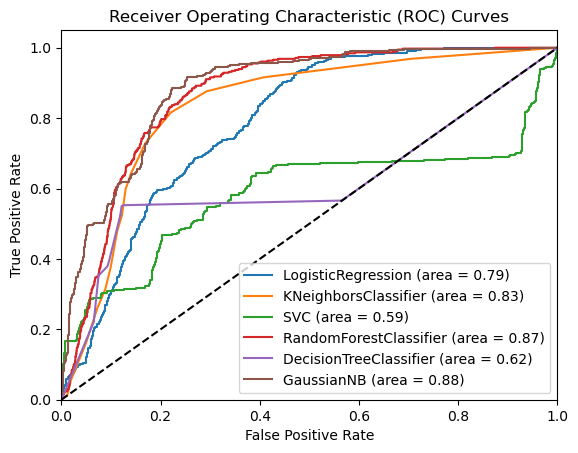

In [102]:
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, ConfusionMatrixDisplay  # Import f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# Dictionary to store the best model and test accuracy for each algorithm
model_accuracy_info = {}

# Define the hyperparameter grid for each model
param_grid = {
    'LogisticRegression': {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'random_state': [42]},
    'KNeighborsClassifier': {'n_neighbors': [3, 5, 7, 10, 12, 13, 15, 20]},
    'SVC': {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto'], 'random_state': [42], 'probability': [True]},
    'RandomForestClassifier': {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20, 30], 'random_state': [42]},
    'DecisionTreeClassifier': {'max_depth': [None, 5, 10, 20], 'random_state': [42]},
    'GaussianNB': {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}
}

# Initialize models
models = {
    'LogisticRegression': LogisticRegression(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'SVC': SVC(),
    'RandomForestClassifier': RandomForestClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'GaussianNB': GaussianNB(),
}

# Ignore convergence and future warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=FutureWarning)

# Function to manually tune hyperparameters
def tune_hyperparameters(model, params, X_train, y_train, X_val, y_val):
    best_model = None
    best_params = {}
    best_auc = 0  # Use AUC-ROC instead of F1 score
    for param in ParameterGrid(params):
        model.set_params(**param)
        model.fit(X_train, y_train)
        probabilities = model.predict_proba(X_val)
        auc = roc_auc_score(y_val, probabilities[:, 1])  # Calculate AUC-ROC
        if auc > best_auc:
            best_auc = auc
            best_model = model
            best_params = param
    return best_model, best_params

# Perform hyperparameter tuning and evaluation
for name, model in models.items():
    print(f"Model: {name}")
    if name in param_grid:
        # Tune hyperparameters
        best_model, best_params = tune_hyperparameters(model, param_grid[name], X_train, y_train, X_val, y_val)
        print(f"Best parameters for {name}: {best_params}")
        model = best_model

    # Predict and evaluate on test data using AUC-ROC
    pred_test = model.predict_proba(X_test)
    auc_test = roc_auc_score(y_test, pred_test[:, 1])  # Calculate AUC-ROC
    accuracy_test = accuracy_score(y_test, pred_test[:, 1] >= 0.5)  # Calculate accuracy

    print(f"Test AUC-ROC for {name}: {auc_test:.4f}\n")
    model_filename = f"{name}_model_V1.joblib"
    joblib.dump(model, model_filename)
    model_accuracy_info[name] = {
        'model': model_filename,
        'auc_roc': auc_test,  # Store AUC-ROC
        'accuracy': accuracy_test
    }

    # Calculate ROC curve and AUC for each model
    fpr, tpr, thresholds = roc_curve(y_test, pred_test[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

    # Print model and F1 score info
for model_name, info in model_accuracy_info.items():
    print(f"Model: {model_name}, File: {info['model']}, Test AUC-ROC: {info['auc_roc']:.4f}, Test Accuracy: {info['accuracy']:.4f}")

plt.plot([0, 1], [0, 1], 'k--')  # Add a diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

## Step 2: Add two more features, percentage of top 3 finish uptill last race (ongoing season) for both drivers and constructors

In [104]:
df_2 = df_final_encoded.drop(["grid", "Driver Average Position (This Year till last race)", "Constructor Average Position (This Year till last race)", "Driver Average Position (This Year till last race)", "Constructor Average Position (This Year till last race)"], axis = 1)

In [105]:
from sklearn.preprocessing import StandardScaler

train_df = df_2[(df_2["year"] >= 1983) & (df_2["year"] <= 2008)]
val_df = df_2[(df_2["year"] >= 2009) & (df_2["year"] <= 2016)]
test_df = df_2[(df_2["year"] >= 2017) & (df_2["year"] <= 2023)]

X_train = train_df[train_df.columns.tolist()[:-1]].values
y_train = train_df['Top 3 Finish'].values
X_val = val_df[train_df.columns.tolist()[:-1]].values
y_val = val_df['Top 3 Finish'].values
X_test = test_df[train_df.columns.tolist()[:-1]].values
y_test = test_df['Top 3 Finish'].values

Model: LogisticRegression
Best parameters for LogisticRegression: {'C': 10, 'random_state': 42}
Test AUC-ROC for LogisticRegression: 0.9060

Model: KNeighborsClassifier
Best parameters for KNeighborsClassifier: {'n_neighbors': 20}
Test AUC-ROC for KNeighborsClassifier: 0.8868

Model: SVC
Best parameters for SVC: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True, 'random_state': 42}
Test AUC-ROC for SVC: 0.7130

Model: RandomForestClassifier
Best parameters for RandomForestClassifier: {'max_depth': 10, 'n_estimators': 100, 'random_state': 42}
Test AUC-ROC for RandomForestClassifier: 0.8812

Model: DecisionTreeClassifier
Best parameters for DecisionTreeClassifier: {'max_depth': 5, 'random_state': 42}
Test AUC-ROC for DecisionTreeClassifier: 0.5222

Model: GaussianNB
Best parameters for GaussianNB: {'var_smoothing': 0.1}
Test AUC-ROC for GaussianNB: 0.9075

Model: LogisticRegression, File: LogisticRegression_model_V2.joblib, Test AUC-ROC: 0.9060, Test Accuracy: 0.8656
Mode

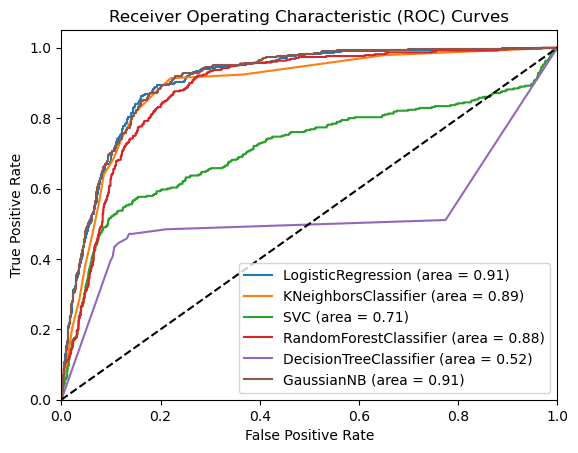

In [106]:
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, ConfusionMatrixDisplay  # Import f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# Dictionary to store the best model and test accuracy for each algorithm
model_accuracy_info = {}

# Define the hyperparameter grid for each model
param_grid = {
    'LogisticRegression': {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'random_state': [42]},
    'KNeighborsClassifier': {'n_neighbors': [3, 5, 7, 10, 12, 13, 15, 20]},
    'SVC': {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto'], 'random_state': [42], 'probability': [True]},
    'RandomForestClassifier': {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20, 30], 'random_state': [42]},
    'DecisionTreeClassifier': {'max_depth': [None, 5, 10, 20], 'random_state': [42]},
    'GaussianNB': {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}
}

# Initialize models
models = {
    'LogisticRegression': LogisticRegression(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'SVC': SVC(),
    'RandomForestClassifier': RandomForestClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'GaussianNB': GaussianNB(),
}

# Ignore convergence and future warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=FutureWarning)

# Function to manually tune hyperparameters
def tune_hyperparameters(model, params, X_train, y_train, X_val, y_val):
    best_model = None
    best_params = {}
    best_auc = 0  # Use AUC-ROC instead of F1 score
    for param in ParameterGrid(params):
        model.set_params(**param)
        model.fit(X_train, y_train)
        probabilities = model.predict_proba(X_val)
        auc = roc_auc_score(y_val, probabilities[:, 1])  # Calculate AUC-ROC
        if auc > best_auc:
            best_auc = auc
            best_model = model
            best_params = param
    return best_model, best_params

# Perform hyperparameter tuning and evaluation
for name, model in models.items():
    print(f"Model: {name}")
    if name in param_grid:
        # Tune hyperparameters
        best_model, best_params = tune_hyperparameters(model, param_grid[name], X_train, y_train, X_val, y_val)
        print(f"Best parameters for {name}: {best_params}")
        model = best_model

    # Predict and evaluate on test data using AUC-ROC
    pred_test = model.predict_proba(X_test)
    auc_test = roc_auc_score(y_test, pred_test[:, 1])  # Calculate AUC-ROC
    accuracy_test = accuracy_score(y_test, pred_test[:, 1] >= 0.5)  # Calculate accuracy

    print(f"Test AUC-ROC for {name}: {auc_test:.4f}\n")
    model_filename = f"{name}_model_V2.joblib"
    joblib.dump(model, model_filename)
    model_accuracy_info[name] = {
        'model': model_filename,
        'auc_roc': auc_test,  # Store AUC-ROC
        'accuracy': accuracy_test
    }

    # Calculate ROC curve and AUC for each model
    fpr, tpr, thresholds = roc_curve(y_test, pred_test[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

    # Print model and F1 score info
for model_name, info in model_accuracy_info.items():
    print(f"Model: {model_name}, File: {info['model']}, Test AUC-ROC: {info['auc_roc']:.4f}, Test Accuracy: {info['accuracy']:.4f}")

plt.plot([0, 1], [0, 1], 'k--')  # Add a diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

## Step 3: Add Average finishing position (driver and constructor) last year, Average finishing position (driver and constructor) for ongoing season

In [117]:
df_3 = df_final_encoded.drop(["grid"], axis = 1)

In [119]:
from sklearn.preprocessing import StandardScaler

train_df = df_3[(df_3["year"] >= 1983) & (df_3["year"] <= 2008)]
val_df = df_3[(df_3["year"] >= 2009) & (df_3["year"] <= 2016)]
test_df = df_3[(df_3["year"] >= 2017) & (df_3["year"] <= 2023)]

X_train = train_df[train_df.columns.tolist()[:-1]].values
y_train = train_df['Top 3 Finish'].values
X_val = val_df[train_df.columns.tolist()[:-1]].values
y_val = val_df['Top 3 Finish'].values
X_test = test_df[train_df.columns.tolist()[:-1]].values
y_test = test_df['Top 3 Finish'].values

Model: LogisticRegression
Best parameters for LogisticRegression: {'C': 100, 'random_state': 42}
Test AUC-ROC for LogisticRegression: 0.9076

Model: KNeighborsClassifier
Best parameters for KNeighborsClassifier: {'n_neighbors': 20}
Test AUC-ROC for KNeighborsClassifier: 0.8873

Model: SVC
Best parameters for SVC: {'C': 0.1, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True, 'random_state': 42}
Test AUC-ROC for SVC: 0.8738

Model: RandomForestClassifier
Best parameters for RandomForestClassifier: {'max_depth': 10, 'n_estimators': 100, 'random_state': 42}
Test AUC-ROC for RandomForestClassifier: 0.8968

Model: DecisionTreeClassifier
Best parameters for DecisionTreeClassifier: {'max_depth': 5, 'random_state': 42}
Test AUC-ROC for DecisionTreeClassifier: 0.5378

Model: GaussianNB
Best parameters for GaussianNB: {'var_smoothing': 0.01}
Test AUC-ROC for GaussianNB: 0.9101

Model: LogisticRegression, File: LogisticRegression_model_V3.joblib, Test AUC-ROC: 0.9076, Test Accuracy: 0.8679
Mo

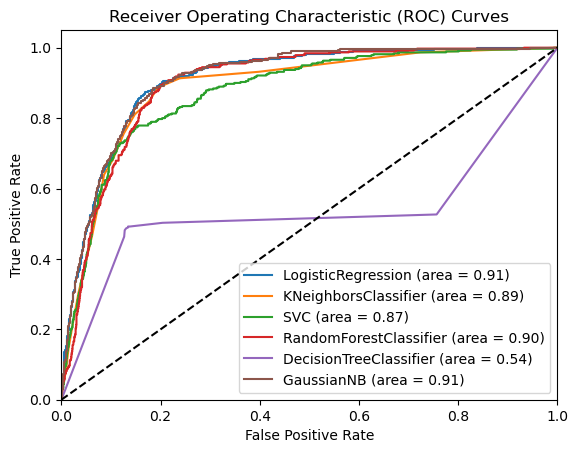

In [121]:
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, ConfusionMatrixDisplay  # Import f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# Dictionary to store the best model and test accuracy for each algorithm
model_accuracy_info = {}

# Define the hyperparameter grid for each model
param_grid = {
    'LogisticRegression': {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'random_state': [42]},
    'KNeighborsClassifier': {'n_neighbors': [3, 5, 7, 10, 12, 13, 15, 20]},
    'SVC': {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto'], 'random_state': [42], 'probability': [True]},
    'RandomForestClassifier': {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20, 30], 'random_state': [42]},
    'DecisionTreeClassifier': {'max_depth': [None, 5, 10, 20], 'random_state': [42]},
    'GaussianNB': {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}
}

# Initialize models
models = {
    'LogisticRegression': LogisticRegression(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'SVC': SVC(),
    'RandomForestClassifier': RandomForestClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'GaussianNB': GaussianNB(),
}

# Ignore convergence and future warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=FutureWarning)

# Function to manually tune hyperparameters
def tune_hyperparameters(model, params, X_train, y_train, X_val, y_val):
    best_model = None
    best_params = {}
    best_auc = 0  # Use AUC-ROC instead of F1 score
    for param in ParameterGrid(params):
        model.set_params(**param)
        model.fit(X_train, y_train)
        probabilities = model.predict_proba(X_val)
        auc = roc_auc_score(y_val, probabilities[:, 1])  # Calculate AUC-ROC
        if auc > best_auc:
            best_auc = auc
            best_model = model
            best_params = param
    return best_model, best_params

# Perform hyperparameter tuning and evaluation
for name, model in models.items():
    print(f"Model: {name}")
    if name in param_grid:
        # Tune hyperparameters
        best_model, best_params = tune_hyperparameters(model, param_grid[name], X_train, y_train, X_val, y_val)
        print(f"Best parameters for {name}: {best_params}")
        model = best_model

    # Predict and evaluate on test data using AUC-ROC
    pred_test = model.predict_proba(X_test)
    auc_test = roc_auc_score(y_test, pred_test[:, 1])  # Calculate AUC-ROC
    accuracy_test = accuracy_score(y_test, pred_test[:, 1] >= 0.5)  # Calculate accuracy

    print(f"Test AUC-ROC for {name}: {auc_test:.4f}\n")
    model_filename = f"{name}_model_V3.joblib"
    joblib.dump(model, model_filename)
    model_accuracy_info[name] = {
        'model': model_filename,
        'auc_roc': auc_test,  # Store AUC-ROC
        'accuracy': accuracy_test
    }

    # Calculate ROC curve and AUC for each model
    fpr, tpr, thresholds = roc_curve(y_test, pred_test[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

    # Print model and F1 score info
for model_name, info in model_accuracy_info.items():
    print(f"Model: {model_name}, File: {info['model']}, Test AUC-ROC: {info['auc_roc']:.4f}, Test Accuracy: {info['accuracy']:.4f}")

plt.plot([0, 1], [0, 1], 'k--')  # Add a diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

# Model Development - With qualifying data

Qualifying is an integral part for predicting podium results. The starting grid is arranged based on drivers performance in qualifying i.e. faster drivers are placed in front.

For a final model, we will add qualifying data to all the features considered in step 3.

In [125]:
df_with_qualifying = df_final_encoded

In [128]:
from sklearn.preprocessing import StandardScaler

train_df = df_with_qualifying[(df_with_qualifying["year"] >= 1983) & (df_with_qualifying["year"] <= 2008)]
val_df = df_with_qualifying[(df_with_qualifying["year"] >= 2009) & (df_with_qualifying["year"] <= 2016)]
test_df = df_with_qualifying[(df_with_qualifying["year"] >= 2017) & (df_with_qualifying["year"] <= 2023)]

X_train = train_df[train_df.columns.tolist()[:-1]].values
y_train = train_df['Top 3 Finish'].values
X_val = val_df[train_df.columns.tolist()[:-1]].values
y_val = val_df['Top 3 Finish'].values
X_test = test_df[train_df.columns.tolist()[:-1]].values
y_test = test_df['Top 3 Finish'].values

Model: LogisticRegression
Best parameters for LogisticRegression: {'C': 10, 'random_state': 42}
Test AUC-ROC for LogisticRegression: 0.9248

Model: KNeighborsClassifier
Best parameters for KNeighborsClassifier: {'n_neighbors': 20}
Test AUC-ROC for KNeighborsClassifier: 0.8937

Model: SVC
Best parameters for SVC: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True, 'random_state': 42}
Test AUC-ROC for SVC: 0.9052

Model: RandomForestClassifier
Best parameters for RandomForestClassifier: {'max_depth': 10, 'n_estimators': 50, 'random_state': 42}
Test AUC-ROC for RandomForestClassifier: 0.9258

Model: DecisionTreeClassifier
Best parameters for DecisionTreeClassifier: {'max_depth': 5, 'random_state': 42}
Test AUC-ROC for DecisionTreeClassifier: 0.7252

Model: GaussianNB
Best parameters for GaussianNB: {'var_smoothing': 0.001}
Test AUC-ROC for GaussianNB: 0.9152

Model: LogisticRegression, File: LogisticRegression_model_V4.joblib, Test AUC-ROC: 0.9248, Test Accuracy: 0.8795
Model

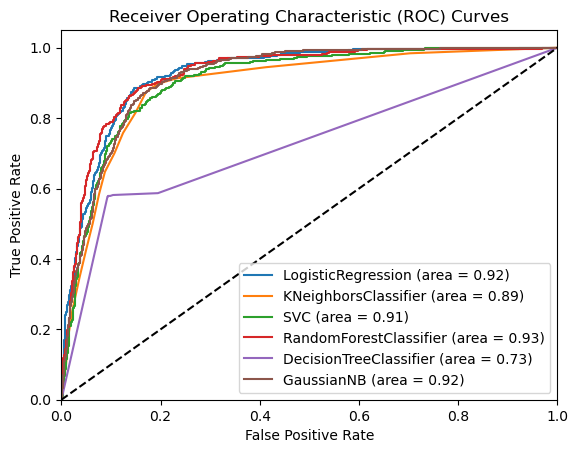

In [130]:
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# Dictionary to store the best model and test accuracy for each algorithm
model_accuracy_info = {}

# Define the hyperparameter grid for each model
param_grid = {
    'LogisticRegression': {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'random_state': [42]},
    'KNeighborsClassifier': {'n_neighbors': [3, 5, 7, 10, 12, 13, 15, 20]},
    'SVC': {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto'], 'random_state': [42], 'probability': [True]},
    'RandomForestClassifier': {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20, 30], 'random_state': [42]},
    'DecisionTreeClassifier': {'max_depth': [None, 5, 10, 20], 'random_state': [42]},
    'GaussianNB': {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}
}

# Initialize models
models = {
    'LogisticRegression': LogisticRegression(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'SVC': SVC(),
    'RandomForestClassifier': RandomForestClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'GaussianNB': GaussianNB(),
}

# Ignore convergence and future warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=FutureWarning)

# Function to manually tune hyperparameters
def tune_hyperparameters(model, params, X_train, y_train, X_val, y_val):
    best_model = None
    best_params = {}
    best_auc = 0  # Use AUC-ROC instead of F1 score
    for param in ParameterGrid(params):
        model.set_params(**param)
        model.fit(X_train, y_train)
        probabilities = model.predict_proba(X_val)
        auc = roc_auc_score(y_val, probabilities[:, 1])  # Calculate AUC-ROC
        if auc > best_auc:
            best_auc = auc
            best_model = model
            best_params = param
    return best_model, best_params

# Perform hyperparameter tuning and evaluation
for name, model in models.items():
    print(f"Model: {name}")
    if name in param_grid:
        # Tune hyperparameters
        best_model, best_params = tune_hyperparameters(model, param_grid[name], X_train, y_train, X_val, y_val)
        print(f"Best parameters for {name}: {best_params}")
        model = best_model

    # Predict and evaluate on test data using AUC-ROC
    pred_test = model.predict_proba(X_test)
    auc_test = roc_auc_score(y_test, pred_test[:, 1])  # Calculate AUC-ROC
    accuracy_test = accuracy_score(y_test, pred_test[:, 1] >= 0.5)  # Calculate accuracy

    print(f"Test AUC-ROC for {name}: {auc_test:.4f}\n")
    model_filename = f"{name}_model_V4.joblib"
    joblib.dump(model, model_filename)
    model_accuracy_info[name] = {
        'model': model_filename,
        'auc_roc': auc_test,  # Store AUC-ROC
        'accuracy': accuracy_test
    }

    # Calculate ROC curve and AUC for each model
    fpr, tpr, thresholds = roc_curve(y_test, pred_test[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

    # Print model and F1 score info
for model_name, info in model_accuracy_info.items():
    print(f"Model: {model_name}, File: {info['model']}, Test AUC-ROC: {info['auc_roc']:.4f}, Test Accuracy: {info['accuracy']:.4f}")

plt.plot([0, 1], [0, 1], 'k--')  # Add a diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()


RandomForestClassifier: {'max_depth': 10, 'n_estimators': 50, 'random_state': 42} appears to be the best model with an ROC score of 0.9258

# F1 Podium Prediction

In [136]:
df_with_qualifying = df_final_encoded

In [138]:
from sklearn.preprocessing import StandardScaler

train_df = df_with_qualifying[(df_with_qualifying["year"] >= 1983) & (df_with_qualifying["year"] <= 2008)]
val_df = df_with_qualifying[(df_with_qualifying["year"] >= 2009) & (df_with_qualifying["year"] <= 2016)]
test_df = df_with_qualifying[(df_with_qualifying["year"] >= 2017) & (df_with_qualifying["year"] <= 2023)]

X_train = train_df[train_df.columns.tolist()[:-1]].values
y_train = train_df['Top 3 Finish'].values
X_val = val_df[train_df.columns.tolist()[:-1]].values
y_val = val_df['Top 3 Finish'].values
X_test = test_df[train_df.columns.tolist()[:-1]].values
y_test = test_df['Top 3 Finish'].values

Model: LogisticRegression
Best parameters for LogisticRegression: {'C': 10, 'random_state': 42}
Test AUC-ROC for LogisticRegression: 0.9248

Model: KNeighborsClassifier
Best parameters for KNeighborsClassifier: {'n_neighbors': 20}
Test AUC-ROC for KNeighborsClassifier: 0.8937

Model: SVC
Best parameters for SVC: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf', 'probability': True, 'random_state': 42}
Test AUC-ROC for SVC: 0.9052

Model: RandomForestClassifier
Best parameters for RandomForestClassifier: {'max_depth': 10, 'n_estimators': 50, 'random_state': 42}
Test AUC-ROC for RandomForestClassifier: 0.9258

Model: DecisionTreeClassifier
Best parameters for DecisionTreeClassifier: {'max_depth': 5, 'random_state': 42}
Test AUC-ROC for DecisionTreeClassifier: 0.7252

Model: GaussianNB
Best parameters for GaussianNB: {'var_smoothing': 0.001}
Test AUC-ROC for GaussianNB: 0.9152

Model: LogisticRegression, File: LogisticRegression_model_V4.joblib, Test AUC-ROC: 0.9248, Test Accuracy: 0.8795
Model

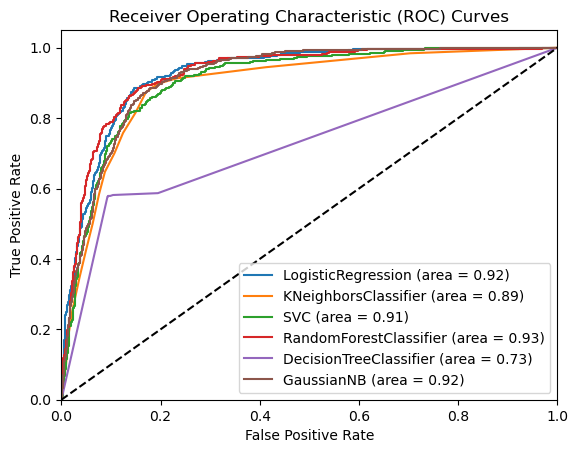

In [140]:
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# Dictionary to store the best model and test accuracy for each algorithm
model_accuracy_info = {}

# Define the hyperparameter grid for each model
param_grid = {
    'LogisticRegression': {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'random_state': [42]},
    'KNeighborsClassifier': {'n_neighbors': [3, 5, 7, 10, 12, 13, 15, 20]},
    'SVC': {'C': [0.1, 1, 10], 'kernel': ['rbf', 'linear'], 'gamma': ['scale', 'auto'], 'random_state': [42], 'probability': [True]},
    'RandomForestClassifier': {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20, 30], 'random_state': [42]},
    'DecisionTreeClassifier': {'max_depth': [None, 5, 10, 20], 'random_state': [42]},
    'GaussianNB': {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]}
}

# Initialize models
models = {
    'LogisticRegression': LogisticRegression(),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'SVC': SVC(),
    'RandomForestClassifier': RandomForestClassifier(),
    'DecisionTreeClassifier': DecisionTreeClassifier(),
    'GaussianNB': GaussianNB(),
}

# Ignore convergence and future warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=FutureWarning)

# Function to manually tune hyperparameters
def tune_hyperparameters(model, params, X_train, y_train, X_val, y_val):
    best_model = None
    best_params = {}
    best_auc = 0  # Use AUC-ROC instead of F1 score
    for param in ParameterGrid(params):
        model.set_params(**param)
        model.fit(X_train, y_train)
        probabilities = model.predict_proba(X_val)
        auc = roc_auc_score(y_val, probabilities[:, 1])  # Calculate AUC-ROC
        if auc > best_auc:
            best_auc = auc
            best_model = model
            best_params = param
    return best_model, best_params

# Perform hyperparameter tuning and evaluation
for name, model in models.items():
    print(f"Model: {name}")
    if name in param_grid:
        # Tune hyperparameters
        best_model, best_params = tune_hyperparameters(model, param_grid[name], X_train, y_train, X_val, y_val)
        print(f"Best parameters for {name}: {best_params}")
        model = best_model

    # Predict and evaluate on test data using AUC-ROC
    pred_test = model.predict_proba(X_test)
    auc_test = roc_auc_score(y_test, pred_test[:, 1])  # Calculate AUC-ROC
    accuracy_test = accuracy_score(y_test, pred_test[:, 1] >= 0.5)  # Calculate accuracy

    print(f"Test AUC-ROC for {name}: {auc_test:.4f}\n")
    model_filename = f"{name}_model_V4.joblib"
    joblib.dump(model, model_filename)
    model_accuracy_info[name] = {
        'model': model_filename,
        'auc_roc': auc_test,  # Store AUC-ROC
        'accuracy': accuracy_test
    }

    # Calculate ROC curve and AUC for each model
    fpr, tpr, thresholds = roc_curve(y_test, pred_test[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

    # Print model and F1 score info
for model_name, info in model_accuracy_info.items():
    print(f"Model: {model_name}, File: {info['model']}, Test AUC-ROC: {info['auc_roc']:.4f}, Test Accuracy: {info['accuracy']:.4f}")

plt.plot([0, 1], [0, 1], 'k--')  # Add a diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

Best parameters for RandomForestClassifier: {'max_depth': 10, 'n_estimators': 50, 'random_state': 42}
Test AUC-ROC for RandomForestClassifier: 0.9258

### Examining Model Behaviour 

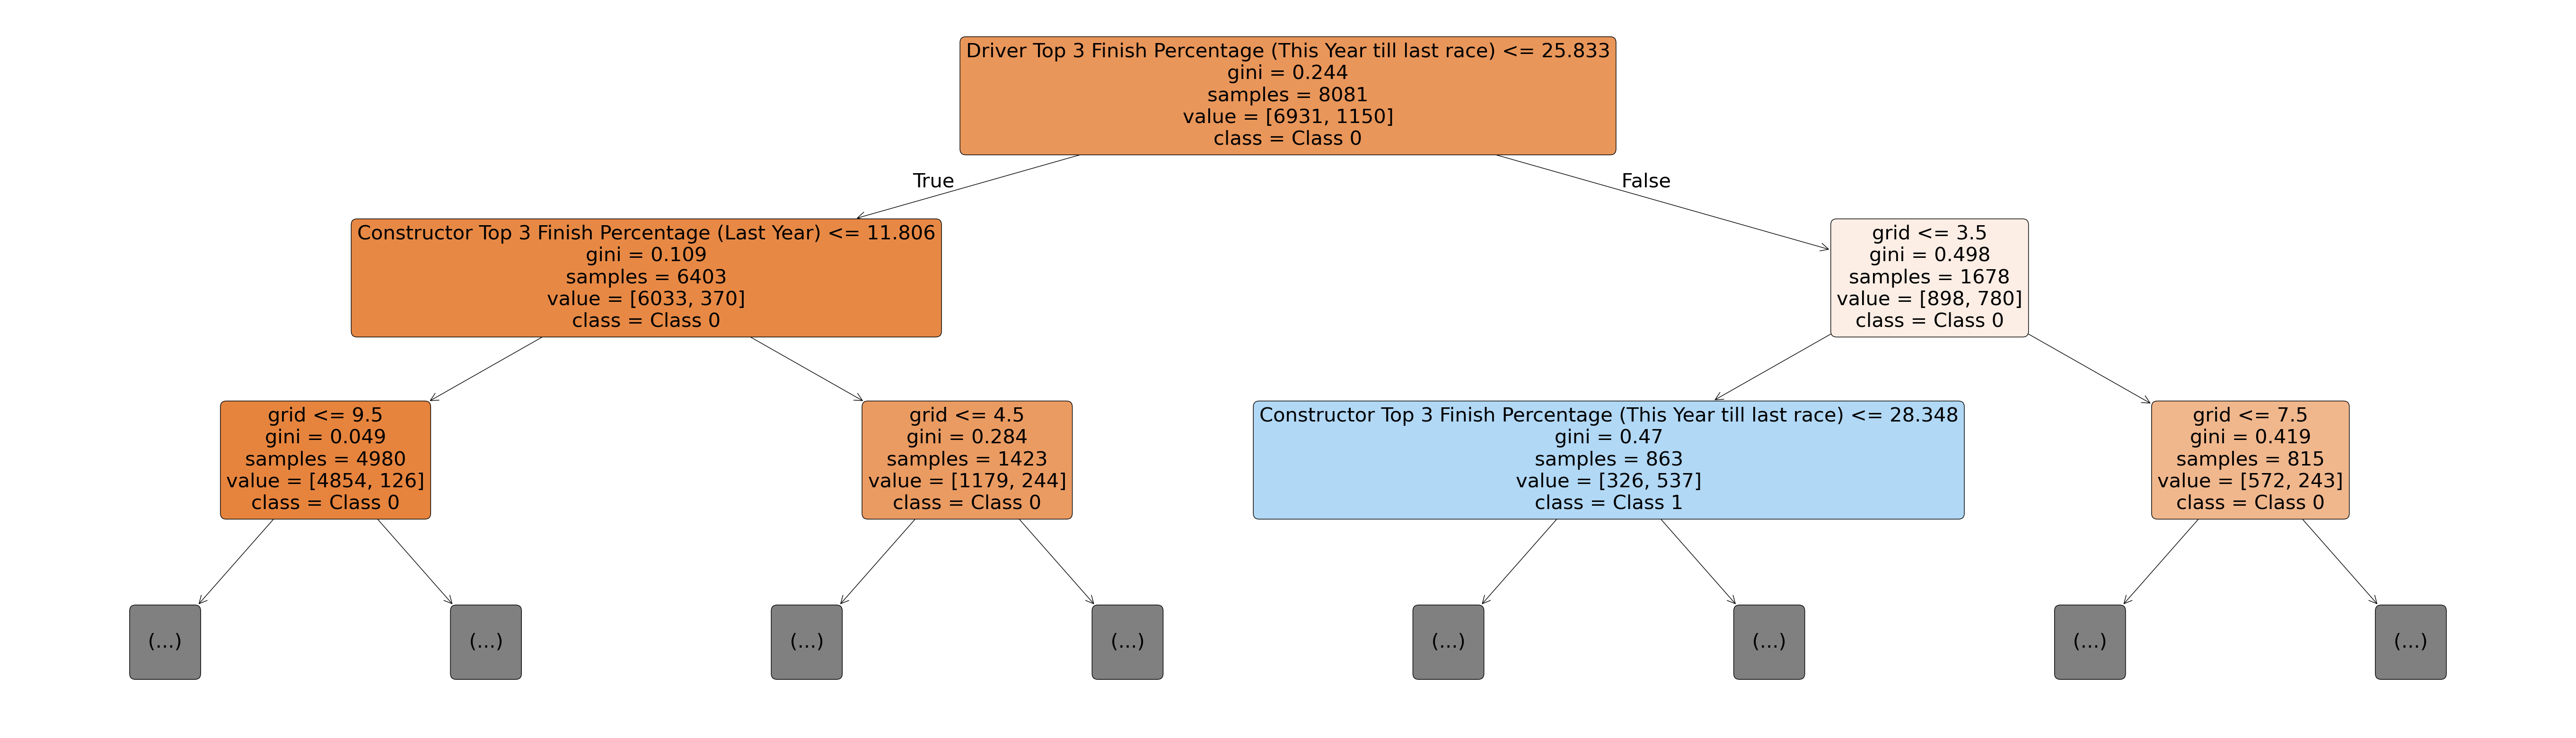

                                              Feature  Importance
5   Driver Top 3 Finish Percentage (This Year till...    0.273399
2                                                grid    0.115633
9   Driver Average Position (This Year till last r...    0.077467
10  Constructor Average Position (This Year till l...    0.072820
6   Constructor Top 3 Finish Percentage (This Year...    0.057756
1                                               round    0.050853
4     Constructor Top 3 Finish Percentage (Last Year)    0.047887
7                     Driver Avg position (Last Year)    0.027598
0                                                year    0.024988
3          Driver Top 3 Finish Percentage (Last Year)    0.022515


In [144]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Define the maximum depth to display
max_depth = 2 # Adjust this value to control the number of levels shown

dt_model = joblib.load("DecisionTreeClassifier_model_V4.joblib")

# Set the size of the plot
plt.figure(figsize=(70, 20))

# Plot the tree with maximum depth
plot_tree(dt_model,
          max_depth=max_depth,
          filled=True,
          rounded=True,
          class_names=['Class 0', 'Class 1'],
          feature_names=train_df.columns,
          fontsize = 30)

# Show the plot
plt.show()

dt_feature_importances = dt_model.feature_importances_

# Create a DataFrame from the feature names and their importances
dt_importances_df = pd.DataFrame({
    'Feature': train_df.columns[:-1],  # Ensure this matches your feature set
    'Importance': dt_feature_importances
})

# Sort the DataFrame by the importances
dt_importances_df.sort_values(by='Importance', ascending=False, inplace=True)

# Print the sorted DataFrame
print(dt_importances_df.head(10))


In [146]:
# Random Forest Classifier
from joblib import load
model = load("RandomForestClassifier_model_V4.joblib")
importances = model.feature_importances_

# Create a DataFrame for visualization
importances_df = pd.DataFrame({'Feature': df_with_qualifying.columns[:-1], 'Importance': importances})

# Sort the DataFrame
importances_df.sort_values(by='Importance', ascending=False, inplace=True)

# Display the feature importances
print(importances_df.head(10))

print(model.get_params(deep = True))

                                              Feature  Importance
2                                                grid    0.113024
5   Driver Top 3 Finish Percentage (This Year till...    0.097392
9   Driver Average Position (This Year till last r...    0.085568
6   Constructor Top 3 Finish Percentage (This Year...    0.081203
10  Constructor Average Position (This Year till l...    0.073770
3          Driver Top 3 Finish Percentage (Last Year)    0.059293
4     Constructor Top 3 Finish Percentage (Last Year)    0.059269
1                                               round    0.050862
7                     Driver Avg position (Last Year)    0.047299
8                Constructor Avg position (Last Year)    0.040191
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 30, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.

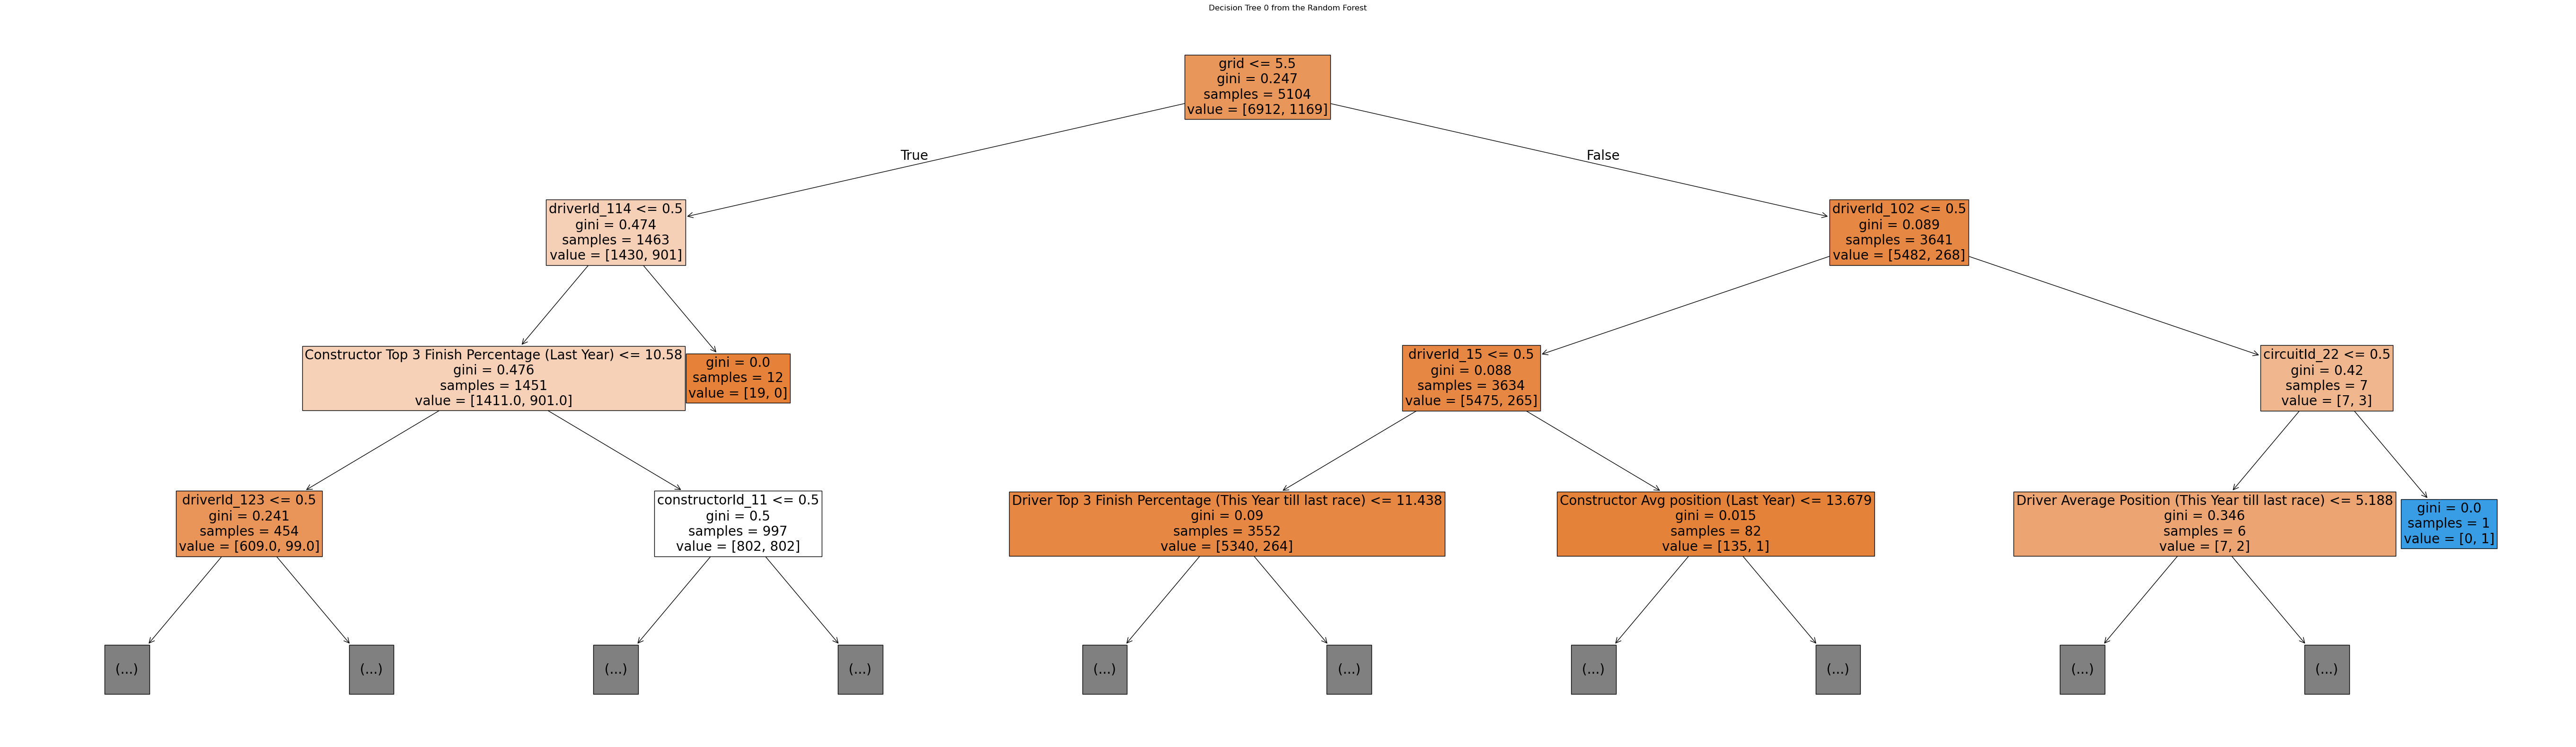

In [148]:
from sklearn import tree
single_tree = model.estimators_[0]

# Visualization
plt.figure(figsize=(70,20))  # Adjust the size as needed
tree.plot_tree(single_tree, filled=True, feature_names=df_with_qualifying.columns[:-1], max_depth=3, fontsize = 20)
plt.title("Decision Tree 0 from the Random Forest")
plt.show()

# Optimization and Hypertuning

We are going to attempt to tune decision threshold values to balance tradeoff between true positive and false positive rates

Optimal Threshold for F1 Score: 0.369


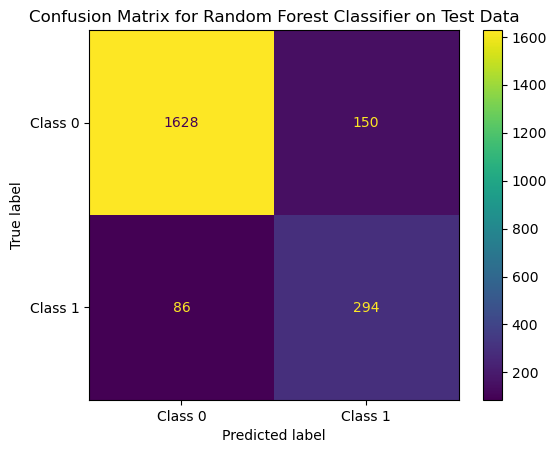

Accuracy of the model: 0.891
F1 Score of the model: 0.714


['RandomForestClassifier_model_V4_with_threshold.joblib']

In [151]:
from sklearn.metrics import precision_recall_curve, f1_score
# Load the model
model = load("RandomForestClassifier_model_V4.joblib")

# Predict probabilities on new data
data_prob = model.predict_proba(X_test)[:, 1]

# Compute Precision-Recall curve
precision, recall, thresholds = precision_recall_curve(y_test, data_prob)
f1_scores = 2 * recall * precision / (recall + precision + 1e-10)

# Find the optimal threshold
optimal_idx = np.nanargmax(f1_scores)  # Using nanargmax to ignore NaN values
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold for F1 Score: {optimal_threshold:.3f}")

# Apply the new threshold to make class predictions
pred_test = (data_prob >= optimal_threshold).astype(int)

# Display the Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, pred_test, display_labels=['Class 0', 'Class 1'])
plt.title("Confusion Matrix for Random Forest Classifier on Test Data")
plt.show()

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, pred_test)
print(f"Accuracy of the model: {accuracy:.3f}")

# Calculate and print the F1 score
f1 = f1_score(y_test, pred_test)
print(f"F1 Score of the model: {f1:.3f}")

# Create a dictionary to hold the model and the threshold
model_data = {
    "model": model,
    "threshold": optimal_threshold
}

# Save the dictionary
model_filename = "RandomForestClassifier_model_V4_with_threshold.joblib"
joblib.dump(model_data, model_filename)

## Prediction Example

In [155]:
from joblib import load
import pandas as pd

round = 7

# Load the model and threshold
model_data = load("RandomForestClassifier_model_V4_with_threshold.joblib")
model = model_data["model"]
optimal_threshold = model_data["threshold"]

# Filter the DataFrame for the year 2023 and round 7 (Spanish Grand Prix)
df_2023 = df_with_qualifying[(df_with_qualifying["year"] == 2023) & (df_with_qualifying["round"] == round)]

# Prepare the feature matrix for prediction
X_2023 = df_2023[df_2023.columns.tolist()[:-1]].values

# Compute probabilities using the model
probabilities = model.predict_proba(X_2023)

# Apply the threshold to make class predictions
pred_test = (probabilities[:, 1] >= optimal_threshold).astype(int)  # Assuming the second column represents the probability of top 3 finish

# Selecting relevant columns and filtering for year 2023 and round 7
df_predict2023 = df_final[["year", "round", "driverId", "constructorId", "grid", "Top 3 Finish"]]
df_predict2023 = df_predict2023[(df_predict2023["year"] == 2023) & (df_predict2023["round"] == round)]



# Create a dictionary to map 'driverId' to 'surname'
driver_name_dict = pd.Series(drivers_df.surname.values, index=drivers_df.driverId).to_dict()

# Replace 'driverId' with corresponding 'surname' in df_predict2023
df_predict2023['driverId'] = df_predict2023['driverId'].map(driver_name_dict)

# Append the predictions to the DataFrame
df_predict2023['Top_3_Finish_Prediction'] = pred_test


# Create a dictionary to map 'constructorId' to 'name'
constructor_name_dict = pd.Series(constructors_df.name.values, index=constructors_df.constructorId).to_dict()

# Replace 'constructorId' with corresponding 'name' in df_predict2023
df_predict2023['constructorId'] = df_predict2023['constructorId'].map(constructor_name_dict)

# Append the predictions to the DataFrame
df_predict2023['Top_3_Finish_Prediction'] = pred_test


# Print the DataFrame with predictions
print(df_predict2023)

       year  round    driverId   constructorId  grid  Top 3 Finish  \
17201  2023      7  Verstappen        Red Bull     1             1   
17202  2023      7    Hamilton        Mercedes     4             1   
17203  2023      7     Russell        Mercedes    12             1   
17204  2023      7       Pérez        Red Bull    11             0   
17205  2023      7       Sainz         Ferrari     2             0   
17206  2023      7      Stroll    Aston Martin     5             0   
17207  2023      7      Alonso    Aston Martin     8             0   
17208  2023      7        Ocon  Alpine F1 Team     6             0   
17209  2023      7        Zhou      Alfa Romeo    13             0   
17210  2023      7       Gasly  Alpine F1 Team    10             0   
17211  2023      7     Leclerc         Ferrari    19             0   
17212  2023      7     Tsunoda      AlphaTauri    15             0   
17214  2023      7    de Vries      AlphaTauri    14             0   
17215  2023      7  

## Predicting Podium with Qualifying Data included

In [158]:
df_with_qualifying = df_final_encoded

In [160]:
from sklearn.preprocessing import StandardScaler

train_df = df_with_qualifying[(df_with_qualifying["year"] >= 1983) & (df_with_qualifying["year"] <= 2008)]
val_df = df_with_qualifying[(df_with_qualifying["year"] >= 2009) & (df_with_qualifying["year"] <= 2016)]
test_df = df_with_qualifying[(df_with_qualifying["year"] >= 2017) & (df_with_qualifying["year"] <= 2023)]

X_train = train_df[train_df.columns.tolist()[:-1]].values
y_train = train_df['Top 3 Finish'].values
X_val = val_df[train_df.columns.tolist()[:-1]].values
y_val = val_df['Top 3 Finish'].values
X_test = test_df[train_df.columns.tolist()[:-1]].values
y_test = test_df['Top 3 Finish'].values

print(X_train)
print(y_train)

[[1983 2 22 ... False False False]
 [1983 2 23 ... False False False]
 [1983 2 2 ... False False False]
 ...
 [2008 18 16 ... False False False]
 [2008 18 19 ... False False False]
 [2008 18 14 ... False False False]]
[1 1 1 ... 0 0 0]


In [162]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

# Initialize the RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Fit and apply the transform
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

# Summarize class distribution
print("Before oversampling: ", Counter(y_train))
print("After oversampling: ", Counter(y_train_resampled))

Before oversampling:  Counter({0: 6931, 1: 1150})
After oversampling:  Counter({1: 6931, 0: 6931})


Model: LogisticRegression
Best parameters for LogisticRegression: {'C': 0.1, 'random_state': 42}
Test AUC-ROC for LogisticRegression: 0.9250

Model: RandomForestClassifier
Best parameters for RandomForestClassifier: {'max_depth': 20, 'n_estimators': 100, 'random_state': 42}
Test AUC-ROC for RandomForestClassifier: 0.9193

Model: LogisticRegression, File: LogisticRegression_model_V5.joblib, Test AUC-ROC: 0.9250, Test Accuracy: 0.8049
Model: RandomForestClassifier, File: RandomForestClassifier_model_V5.joblib, Test AUC-ROC: 0.9193, Test Accuracy: 0.8842


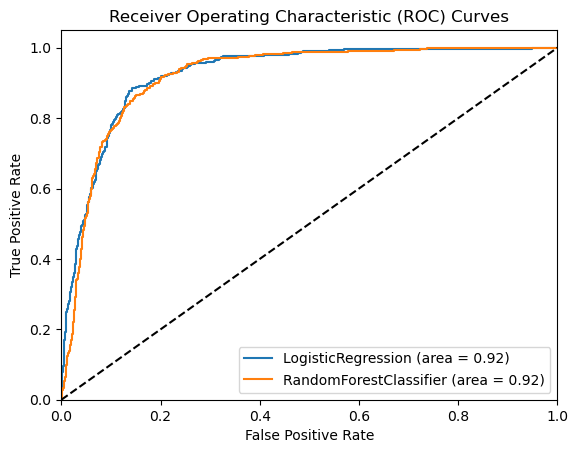

In [164]:
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import f1_score, ConfusionMatrixDisplay  # Import f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

# Dictionary to store the best model and test accuracy for each algorithm
model_accuracy_info = {}

# Define the hyperparameter grid for each model
param_grid = {
    'LogisticRegression': {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'random_state': [42]},
    'RandomForestClassifier': {'n_estimators': [10, 50, 100], 'max_depth': [None, 10, 20, 30], 'random_state': [42]}
}

# Initialize models
models = {
    'LogisticRegression': LogisticRegression(),
    'RandomForestClassifier': RandomForestClassifier()
}

# Ignore convergence and future warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=FutureWarning)

# Function to manually tune hyperparameters
def tune_hyperparameters(model, params, X_train_resampled, y_train_resampled, X_val, y_val):
    best_model = None
    best_params = {}
    best_auc = 0  # Use AUC-ROC instead of F1 score
    for param in ParameterGrid(params):
        model.set_params(**param)
        model.fit(X_train_resampled, y_train_resampled)
        probabilities = model.predict_proba(X_val)
        auc = roc_auc_score(y_val, probabilities[:, 1])  # Calculate AUC-ROC
        if auc > best_auc:
            best_auc = auc
            best_model = model
            best_params = param
    return best_model, best_params

# Perform hyperparameter tuning and evaluation
for name, model in models.items():
    print(f"Model: {name}")
    if name in param_grid:
        # Tune hyperparameters
        best_model, best_params = tune_hyperparameters(model, param_grid[name], X_train_resampled, y_train_resampled, X_val, y_val)
        print(f"Best parameters for {name}: {best_params}")
        model = best_model

    # Predict and evaluate on test data using AUC-ROC
    pred_test = model.predict_proba(X_test)
    auc_test = roc_auc_score(y_test, pred_test[:, 1])  # Calculate AUC-ROC
    accuracy_test = accuracy_score(y_test, pred_test[:, 1] >= 0.5)  # Calculate accuracy

    print(f"Test AUC-ROC for {name}: {auc_test:.4f}\n")
    model_filename = f"{name}_model_V5.joblib"
    joblib.dump(model, model_filename)
    model_accuracy_info[name] = {
        'model': model_filename,
        'auc_roc': auc_test,  # Store AUC-ROC
        'accuracy': accuracy_test
    }

    # Calculate ROC curve and AUC for each model
    fpr, tpr, thresholds = roc_curve(y_test, pred_test[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{name} (area = {roc_auc:.2f})')

    # Print model and F1 score info
for model_name, info in model_accuracy_info.items():
    print(f"Model: {model_name}, File: {info['model']}, Test AUC-ROC: {info['auc_roc']:.4f}, Test Accuracy: {info['accuracy']:.4f}")

plt.plot([0, 1], [0, 1], 'k--')  # Add a diagonal dashed line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()


In [1]:
!pip freeze > requirements.txt
